## Gesture Recognition Training for Summit AI Demo

* Read training data from S3
* Combine multiple json files into single time-series.
* Featurize time-series data
* Train and test Random Forest model
* Train and test Feed-Forward model
* Save model for use by TF-Serve

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import s3fs
import pandas as pd
import numpy as np
import scipy.stats
import time
import multiprocessing as mp
from natsort import natsorted
import json
import matplotlib.pylab as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf

from tensorflow import keras

In [4]:
def collect_featured_data_from_s3(path, fs, label):
    top_dir = fs.ls(path)
    data = []
    
    for files in top_dir:
        # df = None
        bottom_dir = natsorted(fs.ls(files))
        df = combine_multiple_json(bottom_dir)
        df = turn_jsons_into_joint_dataframe(df)
        df = get_accleration_timeseries(df)
        params = [df, label, np.arange(0,100,10)]
        example = featurize(params)
        data.append(example)
        
    return data # a list that has a featurized vector (as a dictioanry) for each folder in top_dir (each capture session)


def mp_collect_featured_data_from_s3(path, fs, label):
    top_dir = fs.ls(path)
    data = []
    data_params = []
    
    for files in top_dir:
        # df = None
        bottom_dir = natsorted(fs.ls(files))
        df = combine_multiple_json(bottom_dir)
        df = turn_jsons_into_joint_dataframe(df)
        df = get_accleration_timeseries(df)
        params = (df, label, np.arange(0,100,10))
        data_params.append(params)
        
    #then = time.time()
    pool = mp.Pool(processes=8)
    data = pool.map(featurize,data_params)
    #print((time.time()-then)/60, "minutes")
        
    return data # a list that has a featurized vector (as a dictioanry) for each folder in top_dir (each capture session)


In [5]:
def combine_multiple_json(bottom_dir):
    
    df = pd.DataFrame([])
    obj = []
    
    for partial_json  in bottom_dir:
        x = fs.open(partial_json)
        data = x.read()
        x.close()
        temp = json.loads(data)
        obj.append(temp['motion'])
        
    return obj # list of motion data in multiple json files representing one capture session

def turn_jsons_into_joint_dataframe(a_list):
    df = pd.DataFrame()
    for item in a_list:
        temp = pd.io.json.json_normalize(item)
        df = df.append(temp, ignore_index=True, sort=False)
        df = df.iloc[:,0:3]
  
    return df # 3xn dataframe of acceleration data  

def get_accleration_timeseries(timeseries):
    
    timeseries = timeseries.apply((lambda x: x**2))
    timeseries = timeseries.sum(axis=1)
    timeseries = timeseries.apply(np.sqrt)
    
    return timeseries # 1xn Series 

def featurize(params):
    ts = params[0]
    label = params[1]
    bins = params[2]
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {'mean_over_median': 0, #dimensionless            
                    'std_over_median': 0, #dimensionless            
                    'length': length,
                    'kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {'mean_over_median': mean/median, #dimensionless            
            'std_over_median': std/median, #dimensionless            
            'length': length,
            'kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    features['label'] = label
    
    
    return features
    

### Get Data

Pull gesture data from S3 and convert it into a featurized representation. 

In [6]:
then = time.time()

path_to_data = 'cchase-rh-demo-4/mock-server-data/motions/2019-02-27'
fs = s3fs.S3FileSystem()
gesture_O = mp_collect_featured_data_from_s3(path_to_data,fs, 'O')
  
print((time.time()-then)/60, "minutes")

/opt/app-root/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/app-root/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


0.7426650325457255 minutes


Process ForkPoolWorker-4:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-6:
  File "/opt/rh/rh-python36/root/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/rh/rh-python36/root/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/rh/rh-python36/root/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/usr/lib64/python3.6/multiproce

In [7]:
then = time.time()

path_to_data = 'cchase-rh-demo-4/mock-server-data/motions/2019-02-26'
fs = s3fs.S3FileSystem()
gesture_X = mp_collect_featured_data_from_s3(path_to_data,fs, 'X')
  
print((time.time()-then)/60, "minutes")

0.6543136954307556 minutes


Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-13:
Process ForkPoolWorker-12:
Process ForkPoolWorker-14:
Process ForkPoolWorker-16:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/rh/rh-python36/root/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/rh/rh-python36/root/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-15:
  File "/opt/rh/rh-python36/root/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/usr/lib64/python3.6/mul

In [8]:
df = pd.DataFrame(gesture_O + gesture_X)

Or load from local csv files

_train_df = pd.read_csv('data/accelerometer/xo/train.csv')
_test_df = pd.read_csv('data/accelerometer/xo/test.csv')

df = pd.concat((_test_df, _train_df))

del _train_df
del _test_df

### Model Training

Split the data for training and testing with both a Random Forest model and a Feed-Forward network. 

In [9]:
df = df.dropna()

In [10]:
train_df, test_df = train_test_split(df, train_size=0.75)
print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (342, 14)
test size = (114, 14)
O    200
X    142
Name: label, dtype: int64
O    71
X    43
Name: label, dtype: int64


/opt/app-root/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
train_df = train_df.dropna()
test_df = test_df.dropna()

#### Random Forest (sklearn)

In [12]:
model = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=10)

model.fit(train_df.drop('label', axis=1), train_df['label'])

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.9678362573099415, test_acc = 0.8859649122807017


Text(0, 0.5, 'predicted')

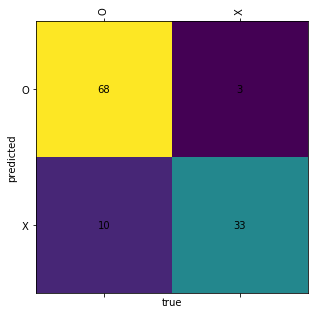

In [13]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

#### Feed-Forward (TF)

In [14]:
one_hot = np.array(train_df['label'])
label_encoder = LabelEncoder()
integer_encoder = label_encoder.fit_transform(one_hot)
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoder = integer_encoder.reshape(len(integer_encoder),1)
train_label = one_hot_encoder.fit_transform(integer_encoder)

one_hot = np.array(test_df['label'])
label_encoder = LabelEncoder()
integer_encoder = label_encoder.fit_transform(one_hot)
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoder = integer_encoder.reshape(len(integer_encoder),1)
test_label = one_hot_encoder.fit_transform(integer_encoder)

In [15]:
# important caveats here.. if we want to export it to .h5, then we have to use
# the keras.activations API instead of the tf.nn
# (possible solution is to export model JSON and weights separately)
model = keras.Sequential([
    keras.layers.Dense(10, activation=keras.activations.relu, input_shape=(13,)),
    keras.layers.Dense(2, activation=keras.activations.softmax)
]) 

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
optimizer = keras.optimizers.Adam(lr=1e-3)
loss = keras.losses.binary_crossentropy
metrics = ['accuracy']

model.compile(optimizer=optimizer,  loss=loss, metrics=metrics)

In [17]:
history = model.fit( train_df.drop('label', axis=1), train_label, epochs=5000, batch_size=100, verbose=0)

Instructions for updating:
Use tf.cast instead.


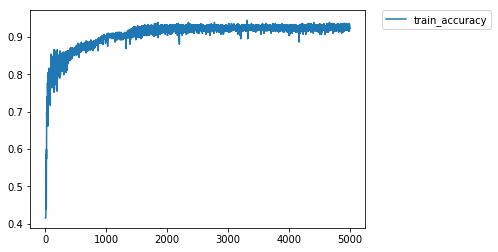

In [18]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [19]:
test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1), test_label)

print('Test accuracy:', test_acc)

114/114 [==============================] - 0s 314us/sample - loss: 0.4804 - acc: 0.8333
Test accuracy: 0.8333333


#### Save Model for Use by TF-Serve

In [20]:
import os
from pathlib import Path
from datetime import datetime as dt

save = True
ver = int(dt.now().timestamp())

if save:
    for fmt in ['pb', 'hdf5', 'json']:
        # save model as hdf5
        MODEL_DIR = f"models/{fmt}"
        export_path = Path(MODEL_DIR, str(ver))

        if fmt == 'pb':
            # simple_save can not handle existing repository
            !rm -r {export_path}

            # Inspired by https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
            # to save model for TF-serving
            tf.saved_model.simple_save(
                tf.keras.backend.get_session(),
                str(export_path),
                inputs={'input_data': model.input},
                outputs={t.name:t for t in model.outputs})
            
        elif fmt == 'hdf5':
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            model_path = Path(export_path, 'saved_model.h5') 
            
            # hdf5
            model.save(model_path)
            
        else:
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            # json
            model_spec_path = Path(
                export_path, 'saved_model_spec.json'
            )
            model_weights_path = Path(
                export_path, 'checkpoint')
            
            model_spec_path.write_text(model.to_json(), encoding='utf-8')
            model.save_weights(str(model_weights_path))

        print('\nSaved model:')
        !ls -l {export_path}

rm: cannot remove ‘models/pb/1553780586’: No such file or directory
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/pb/1553780586/saved_model.pb

Saved model:
total 152
-rw-r--r--. 1 default 1000660000 151017 Mar 28 13:43 saved_model.pb
drwxr-sr-x. 2 default 1000660000   4096 Mar 28 13:43 variables

Saved model:
total 24
-rw-r--r--. 1 default 1000660000 23504 Mar 28 13:43 saved_model.h5

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.

Saved m

#### demonstrate model loading from JSON

In [21]:
loaded_model = tf.keras.models.model_from_json(model_spec_path.read_text())

loaded_model.load_weights(str(model_weights_path))
loaded_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [22]:
test_loss, test_acc = loaded_model.evaluate(test_df.drop('label', axis=1), test_label)

print('Test accuracy:', test_acc)

114/114 [==============================] - 0s 326us/sample - loss: 0.4804 - acc: 0.8333
Test accuracy: 0.8333333


In [23]:
%%bash

oc get bc

NAME                              TYPE      FROM                            LATEST
jupyter-notebook-tensorflow-img   Source    Git@feature/add-serving-infra   4
tf-serving                        Source    Git@feature/add-serving-infra   3


In [24]:
%%bash

oc start-build tf-serving --from-dir .

build.build.openshift.io/tf-serving-4 started


Uploading directory "." as binary input for the build ...
.
Uploading finished


In [25]:
%%bash

oc logs -f build.build.openshift.io/tf-serving-2

Receiving source from STDIN as archive ...
Caching blobs under "/var/cache/blobs".
Getting image source signatures
Copying blob sha256:da59b306fcf51d4fe2f11ef4660a9b72a48788d81a3685c57687ab8e22295229
Copying blob sha256:e23b0afac3fa3bc3736efa2a2f7b05f810ecc499278d804c4d531b1ec52842b2
Copying blob sha256:f7b75f6aafa54dab49fe66edd29f598e6d1a6af65d1d889296eaf7bdb6022baf
Copying blob sha256:609fb28361983de87f660cd05479f8e7ac96bffe45ca889c986526ca013f6a73
Copying blob sha256:a81b2823ccbe655fe5c6c8515c4f0342c18dee04c3b8b60222fe8e615f56dac8
Copying config sha256:cdee27da3387016ce799020021fba749bc7269aa45886cfe935d7dd12fc74840
Writing manifest to image destination
Storing signatures
cdee27da3387016ce799020021fba749bc7269aa45886cfe935d7dd12fc74840
Generating dockerfile with builder image image-registry.openshift-image-registry.svc:5000/openshift/python@sha256:60419af66e84663ebbfde4a68c3a702f2dabbf416c71e998dbbda95b36f81be9
STEP 1: FROM image-registry.openshift-image-registry.svc:5000/openshift/

In [33]:
%%bash

oc process tf-serving-knative -p REVISION=7 | oc apply -f -


service.serving.knative.dev/tf-serving-knative-demo configured


In [40]:
%%bash

while oc get pods | grep tf-serving-knative | grep -v Running; do 
    oc get pods | grep tf-serving-knative
    sleep 1
done


Process is interrupted.


In [35]:
%%bash --out KSERVICE_DOMAIN

oc get kservice tf-serving-knative-demo -o jsonpath='{.status.domain}'

In [36]:
import requests
INGRESS_GATEWAY="a1750b0f2514211e989f40eadd03a211-1243510837.us-east-1.elb.amazonaws.com"

In [37]:
KSERVICE_DOMAIN

'tf-serving-knative-demo.tf-demo.example.com'

In [38]:
data = {
  "instances": [
    [
      0.625899,
      0.23741,
      0.035971,
      0.035971,
      0.028777,
      0.014388,
      0.021583,
      0,
      0,
      4.7488,
      139,
      1.359591,
      1.667831
    ]
  ],
  "signature": "serving_default"
}

In [39]:
json_response = requests.post("http://%s/model/predict" % INGRESS_GATEWAY, json=data, headers={"Host": KSERVICE_DOMAIN, "Content-Type":"application/json"})
json_response.content

b'{"predictions": [[0.00013503474474418908, 0.999864935874939]]}\n'